## Time series analyse

## We choose a window of 60 time steps
## We want to learn 48 steps and predict 12 steps.
## Each step = 1 second

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from configs.utils_2 import windowing, windowing_array
from sklearn.model_selection import train_test_split
from configs.utils_2 import split_sequence, split_sequence_long
import math

%load_ext autoreload
%autoreload 2

2024-04-25 22:37:00.838234: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 22:37:01.029893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 22:37:01.029932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 22:37:01.063515: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 22:37:01.136975: I tensorflow/core/platform/cpu_feature_guar

### Data Exploration

In [2]:
csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [3]:
# show head
print(data.shape)
data.head()

(4597200, 6)


,pos.x,pos.y,pos.z,heading,velocity,weather
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2


In [4]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

4597200


### Time

In [8]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [9]:
temp_data = data

In [10]:
temp_data.head()

,pos.x,pos.y,pos.z,heading,velocity,weather,Minute sin,Minute cos,Date Time
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2,-1.792514e-08,1.000000,2009-01-01 00:00:00
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2,1.045284e-01,0.994522,2009-01-01 00:00:01
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2,2.079117e-01,0.978148,2009-01-01 00:00:02
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2,3.090170e-01,0.951057,2009-01-01 00:00:03
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2,4.067366e-01,0.913545,2009-01-01 00:00:04


In [11]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597200 entries, 0 to 4597199
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   pos.x       float64
 1   pos.y       float64
 2   pos.z       float64
 3   heading     float64
 4   velocity    float64
 5   weather     int64  
 6   Minute sin  float64
 7   Minute cos  float64
dtypes: float64(7), int64(1)
memory usage: 280.6 MB


In [13]:
data.head()

,pos.x,pos.y,pos.z,heading,velocity,weather,Minute sin,Minute cos
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2,-1.792514e-08,1.000000
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2,1.045284e-01,0.994522
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2,2.079117e-01,0.978148
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2,3.090170e-01,0.951057
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2,4.067366e-01,0.913545


### Windowing
We choose a window of 60 time steps
We want to learn 48 steps and predict 12 steps.

In [14]:
window_size = 60
grouped_data = windowing_array(data, window_size)

In [15]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

76620
60
8


### Slice and Split sequence 

In [16]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [17]:
x_train_init.shape, x_test_init.shape

((61296, 60, 8), (15324, 60, 8))

In [18]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence_long(x_train_init)

In [19]:
x_train.shape, y_train.shape

((61296, 48, 8), (61296, 12, 8))

In [20]:
x_train.shape[0], x_train.shape[1], x_train.shape[2]

(61296, 48, 8)

In [21]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [22]:
y_train.shape

(61296, 12, 2)

In [23]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence_long(x_test_init)

In [24]:
x_test.shape, y_test.shape

((15324, 48, 8), (15324, 12, 8))

In [25]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [26]:
y_test.shape

(15324, 12, 2)

In [51]:
y = x_test[100]
y.shape

(48, 8)

In [52]:
y

array([[-1.74380478e+02,  1.38778503e+02,  3.63910682e-02,
         2.03316423e+00,  2.84788703e+01,  0.00000000e+00,
        -1.13481336e-08,  1.00000000e+00],
       [-1.75081146e+02,  1.38408676e+02,  3.63602452e-02,
         2.05624878e+00,  2.85647474e+01,  0.00000000e+00,
         1.04528455e-01,  9.94521896e-01],
       [-1.75768967e+02,  1.38016068e+02,  3.64127718e-02,
         2.08465912e+00,  2.84874103e+01,  0.00000000e+00,
         2.07911685e-01,  9.78147602e-01],
       [-1.76443207e+02,  1.37602615e+02,  3.64324562e-02,
         2.11607270e+00,  2.84873952e+01,  0.00000000e+00,
         3.09016978e-01,  9.51056522e-01],
       [-1.77110443e+02,  1.37177582e+02,  3.64315026e-02,
         2.13818653e+00,  2.84843674e+01,  0.00000000e+00,
         4.06736630e-01,  9.13545464e-01],
       [-1.77772598e+02,  1.36744934e+02,  3.64316925e-02,
         2.15155772e+00,  2.84697138e+01,  0.00000000e+00,
         4.99999990e-01,  8.66025410e-01],
       [-1.78419937e+02,  1.362947

In [54]:
pos_x = y[:, :1]
pos_x

array([[-174.38047791],
       [-175.08114624],
       [-175.76896667],
       [-176.44320679],
       [-177.11044312],
       [-177.77259827],
       [-178.41993713],
       [-179.05128479],
       [-179.67544556],
       [-180.28320312],
       [-180.87503052],
       [-181.45974731],
       [-182.02653503],
       [-182.5753479 ],
       [-183.11480713],
       [-183.64749146],
       [-184.16136169],
       [-184.65472412],
       [-185.13790894],
       [-185.59977722],
       [-186.04116821],
       [-186.47267151],
       [-186.88215637],
       [-187.27018738],
       [-187.64678955],
       [-188.01528931],
       [-188.36224365],
       [-188.68571472],
       [-188.99693298],
       [-189.28356934],
       [-189.54660034],
       [-189.79745483],
       [-190.02349854],
       [-190.22567749],
       [-190.41499329],
       [-190.5791626 ],
       [-190.71969604],
       [-190.8474884 ],
       [-190.9667511 ],
       [-191.0637207 ],
       [-191.13717651],
       [-191.198

In [56]:
pos_y = y[:, 1:2]
pos_y

array([[138.77850342],
       [138.40867615],
       [138.0160675 ],
       [137.60261536],
       [137.17758179],
       [136.74493408],
       [136.29478455],
       [135.82575989],
       [135.34519958],
       [134.84410095],
       [134.3230896 ],
       [133.78970337],
       [133.23712158],
       [132.66734314],
       [132.0877533 ],
       [131.50190735],
       [130.90296936],
       [130.2901001 ],
       [129.66821289],
       [129.03086853],
       [128.37840271],
       [127.7155838 ],
       [127.03839874],
       [126.34877014],
       [125.65172577],
       [124.95027161],
       [124.24098969],
       [123.52364349],
       [122.80041504],
       [122.06781006],
       [121.325737  ],
       [120.57603455],
       [119.81773376],
       [119.05251312],
       [118.28283691],
       [117.50924683],
       [116.73299408],
       [115.95448303],
       [115.17407227],
       [114.39187622],
       [113.60775757],
       [112.82059479],
       [112.03066254],
       [111

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pos(pos_x, pos_y):

    # Convert 2D arrays to 1D arrays
    pos_x = np.squeeze(pos_x)
    pos_y = np.squeeze(pos_y)

    # Print original arrays
    print("Original pos.x:", pos_x)
    print("Original pos.y:", pos_y)
    
    # Plot original pos.x and pos.y
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(pos_x, pos_y, label='(pos.x, pos.y)')
    plt.title('Original pos.x')
    plt.legend()
    
    # Shuffle pos.x
    pos_x_shuffled = np.random.permutation(pos_x)
    
    # Print shuffled pos.x
    print("Shuffled pos.x:", pos_x_shuffled)
    
    # Plot shuffled pos.x and pos.y
    plt.subplot(2, 1, 2)
    plt.plot(pos_x_shuffled, pos_y, label='(pos.x, pos.y)')
    plt.title('Shuffled pos.x')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Original pos.x: [-174.38047791 -175.08114624 -175.76896667 -176.44320679 -177.11044312
 -177.77259827 -178.41993713 -179.05128479 -179.67544556 -180.28320312
 -180.87503052 -181.45974731 -182.02653503 -182.5753479  -183.11480713
 -183.64749146 -184.16136169 -184.65472412 -185.13790894 -185.59977722
 -186.04116821 -186.47267151 -186.88215637 -187.27018738 -187.64678955
 -188.01528931 -188.36224365 -188.68571472 -188.99693298 -189.28356934
 -189.54660034 -189.79745483 -190.02349854 -190.22567749 -190.41499329
 -190.5791626  -190.71969604 -190.8474884  -190.9667511  -191.0637207
 -191.13717651 -191.19862366 -191.25216675 -191.30056763 -191.34565735
 -191.37962341 -191.4041748  -191.42428589]
Original pos.y: [138.77850342 138.40867615 138.0160675  137.60261536 137.17758179
 136.74493408 136.29478455 135.82575989 135.34519958 134.84410095
 134.3230896  133.78970337 133.23712158 132.66734314 132.0877533
 131.50190735 130.90296936 130.2901001  129.66821289 129.03086853
 128.37840271 127.71558

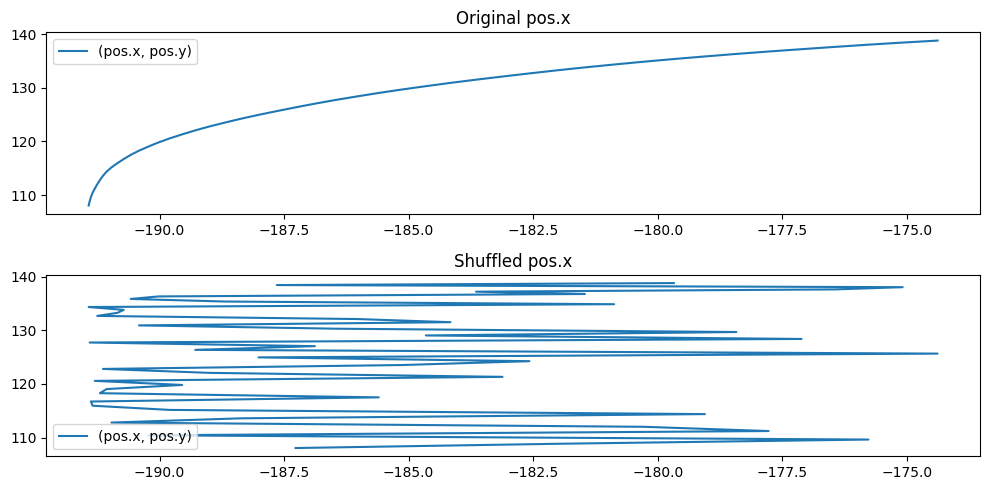

In [59]:
plot_pos(pos_x, pos_y)

## Display correlation

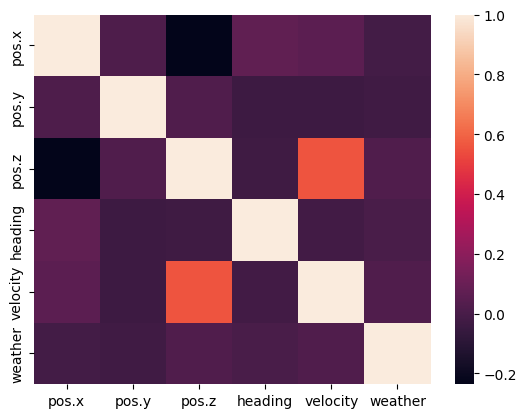

In [61]:
# import modules 
import matplotlib.pyplot as mp 
import pandas as pd 
import seaborn as sb 


# plotting correlation heatmap 
dataplot=sb.heatmap(csv_input.corr()) 

# displaying heatmap 
mp.show()

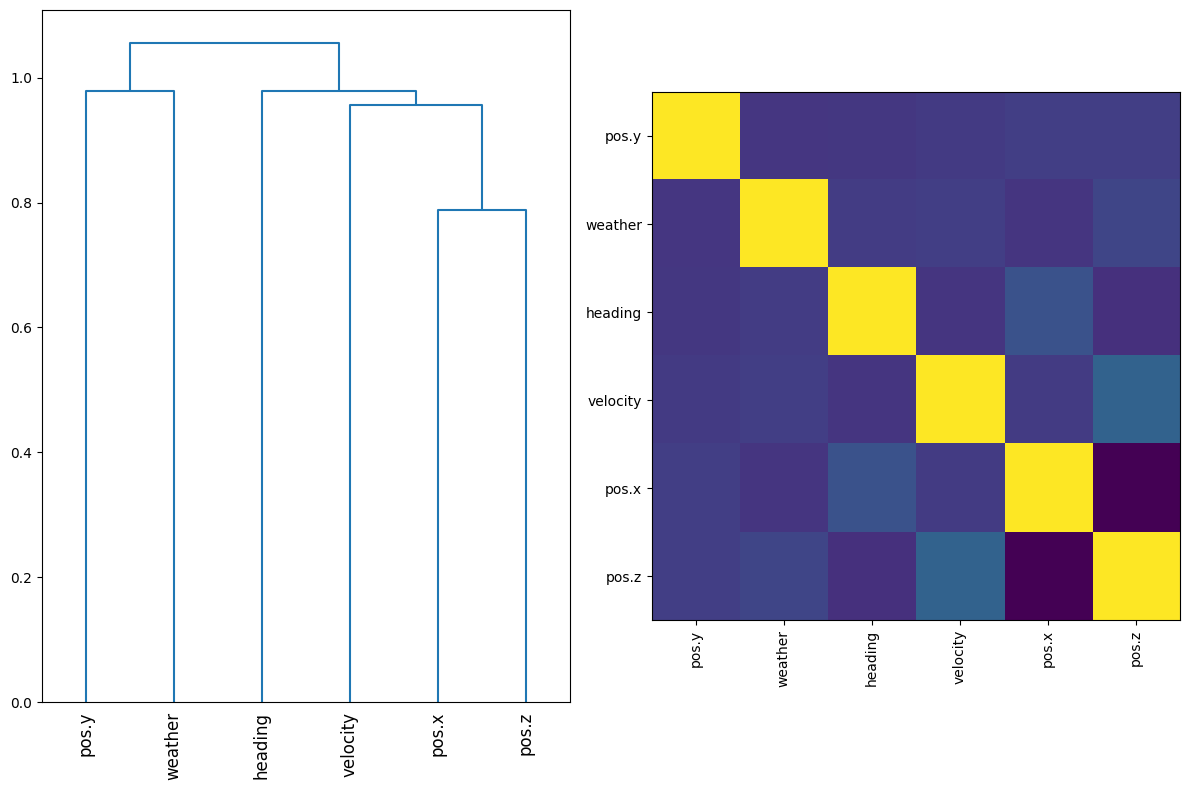

In [62]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(csv_input).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=csv_input.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [63]:
import numpy as np
from scipy.stats import pearsonr

def generate_perturbations(time_series_matrix):
    # Step 1: Compute correlation matrix
    correlation_matrix = np.corrcoef(np.transpose(time_series_matrix))
    num_features = len(correlation_matrix)

    # Step 2: Identify feature pairs with significant correlation coefficients
    correlated_features = {}
    for i in range(num_features):
        for j in range(i + 1, num_features):
            correlation = correlation_matrix[i, j]
            if abs(correlation) > 0.5:  # Adjust threshold as needed
                correlated_features[(i, j)] = correlation

    # Step 3: Generate perturbation values
    perturbation_values = {}
    for feature_pair, correlation in correlated_features.items():
        feature1, feature2 = feature_pair
        perturbation_values[feature1] = np.random.normal(0, abs(correlation), size=len(time_series_matrix))
        perturbation_values[feature2] = np.random.normal(0, abs(correlation), size=len(time_series_matrix))

    # Step 4: Ensure perturbation values do not result in unrealistic data
    for feature_index in range(num_features):
        mean = np.mean(time_series_matrix[:, feature_index])
        std = np.std(time_series_matrix[:, feature_index])
        perturbation_values[feature_index] = np.clip(perturbation_values[feature_index], mean - 2 * std, mean + 2 * std)

    return perturbation_values

# Example usage
time_series_matrix = np.array([[-1.74, 1.23, 3.5], [23.3, 4.5, 1.2], [3.4, 1.2, 4.4]])
perturbation_values = generate_perturbations(time_series_matrix)
print("Perturbation values:")
print(perturbation_values)


Perturbation values:
{0: array([0.77938837, 0.3847716 , 0.76979168]), 1: array([-0.46412877,  0.49393656, -0.78722456]), 2: array([0.33848228, 0.55701559, 0.33848228])}


In [68]:
import numpy as np

def perturb_time_series(matrix):
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(matrix, rowvar=False)
    
    # Initialize perturbation matrix
    perturbed_matrix = np.copy(matrix)
    
    # Iterate over each feature
    for i in range(matrix.shape[1]):
        # Find indices of features with high correlation with feature i
        correlated_features = np.where((np.abs(corr_matrix[i]) > 0.7) & (np.abs(corr_matrix[i]) < 1.0))[0]
        
        # Compute perturbation values based on correlation grade
        for j in correlated_features:
            if i != j:
                perturbation_factor = corr_matrix[i, j]
                perturbed_matrix[:, j] += perturbation_factor * perturbed_matrix[:, i]
    
    return perturbed_matrix

# Example usage
time_series_matrix = np.array([[-1.74, 1.23, 3.5], [23.3, 4.5, 1.2], [3.4, 1.2, 4.4]])
perturbed_matrix = perturb_time_series(time_series_matrix)
print(perturbed_matrix)


[[ -7.10988488  -5.78420078   5.50708823]
 [ 90.93956025  71.57464239 -45.8970881 ]
 [ 10.50555629   7.41912047  -2.99644839]]


In [66]:
corr_matrix = np.corrcoef(time_series_matrix, rowvar=False)
corr_matrix

array([[ 1.        ,  0.97936939, -0.89077258],
       [ 0.97936939,  1.        , -0.9642297 ],
       [-0.89077258, -0.9642297 ,  1.        ]])

In [78]:
corr_matrix_2 = np.corrcoef(y, rowvar=False)
corr_matrix_2

/home/ab000840/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab000840/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


array([[ 1.        ,  0.93449719, -0.02466257, -0.97094508,  0.04093063,
                nan,  0.62141107,  0.83997336],
       [ 0.93449719,  1.        ,  0.02579737, -0.99127599, -0.02395521,
                nan,  0.83895752,  0.61937884],
       [-0.02466257,  0.02579737,  1.        , -0.01846874, -0.86960932,
                nan,  0.10935382, -0.04962045],
       [-0.97094508, -0.99127599, -0.01846874,  1.        ,  0.01132747,
                nan, -0.78284027, -0.70985251],
       [ 0.04093063, -0.02395521, -0.86960932,  0.01132747,  1.        ,
                nan, -0.12224578,  0.08030885],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan],
       [ 0.62141107,  0.83895752,  0.10935382, -0.78284027, -0.12224578,
                nan,  1.        ,  0.25316634],
       [ 0.83997336,  0.61937884, -0.04962045, -0.70985251,  0.08030885,
                nan,  0.25316634,  1.        ]])

In [69]:
perturbed_matrix = perturb_time_series(y)

/home/ab000840/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab000840/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [71]:
y

array([[-1.74380478e+02,  1.38778503e+02,  3.63910682e-02,
         2.03316423e+00,  2.84788703e+01,  0.00000000e+00,
        -1.13481336e-08,  1.00000000e+00],
       [-1.75081146e+02,  1.38408676e+02,  3.63602452e-02,
         2.05624878e+00,  2.85647474e+01,  0.00000000e+00,
         1.04528455e-01,  9.94521896e-01],
       [-1.75768967e+02,  1.38016068e+02,  3.64127718e-02,
         2.08465912e+00,  2.84874103e+01,  0.00000000e+00,
         2.07911685e-01,  9.78147602e-01],
       [-1.76443207e+02,  1.37602615e+02,  3.64324562e-02,
         2.11607270e+00,  2.84873952e+01,  0.00000000e+00,
         3.09016978e-01,  9.51056522e-01],
       [-1.77110443e+02,  1.37177582e+02,  3.64315026e-02,
         2.13818653e+00,  2.84843674e+01,  0.00000000e+00,
         4.06736630e-01,  9.13545464e-01],
       [-1.77772598e+02,  1.36744934e+02,  3.64316925e-02,
         2.15155772e+00,  2.84697138e+01,  0.00000000e+00,
         4.99999990e-01,  8.66025410e-01],
       [-1.78419937e+02,  1.362947

In [70]:
perturbed_matrix

array([[-625.27043231, -363.08746454,  -24.70158039,  532.57656257,
          28.44722427,    0.        , -173.18658249, -284.12026143],
       [-630.1216569 , -367.57861709,  -24.77631403,  537.22810388,
          28.53312815,    0.        , -175.28739624, -285.93455867],
       [-634.97572616, -372.09491078,  -24.70896879,  541.89516926,
          28.45574546,    0.        , -177.40116021, -287.75146758],
       [-639.81996143, -376.62354423,  -24.70892109,  546.56443532,
          28.45571324,    0.        , -179.52239724, -289.56619483],
       [-644.64830254, -381.14529356,  -24.7062897 ,  551.2193684 ,
          28.4526862 ,    0.        , -181.64254978, -291.37757433],
       [-649.46208156, -385.65780721,  -24.6935465 ,  555.86081187,
          28.43803248,    0.        , -183.76108052, -293.18700324],
       [-654.2585988 , -390.17759352,  -24.57246408,  560.50228311,
          28.29885464,    0.        , -185.88646912, -294.99194505],
       [-659.03258973, -394.70278085,  -2

In [73]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pos(pos_x, pos_y, pos_x_shuffled):

    # Convert 2D arrays to 1D arrays
    pos_x = np.squeeze(pos_x)
    pos_y = np.squeeze(pos_y)

    # Print original arrays
    #print("Original pos.x:", pos_x)
    #print("Original pos.y:", pos_y)
    
    # Plot original pos.x and pos.y
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(pos_x, pos_y, label='(pos.x, pos.y)')
    plt.title('Original pos.x')
    plt.legend()

    
    # Print shuffled pos.x
    #print("Shuffled pos.x:", pos_x_shuffled)
    
    # Plot shuffled pos.x and pos.y
    plt.subplot(2, 1, 2)
    plt.plot(pos_x_shuffled, pos_y, label='(pos.x, pos.y)')
    plt.title('Shuffled pos.x')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [72]:
pos_x = y[:, :1]
pos_y = y[:, 1:2]
pos_x_shuffle = perturbed_matrix[:, :1]

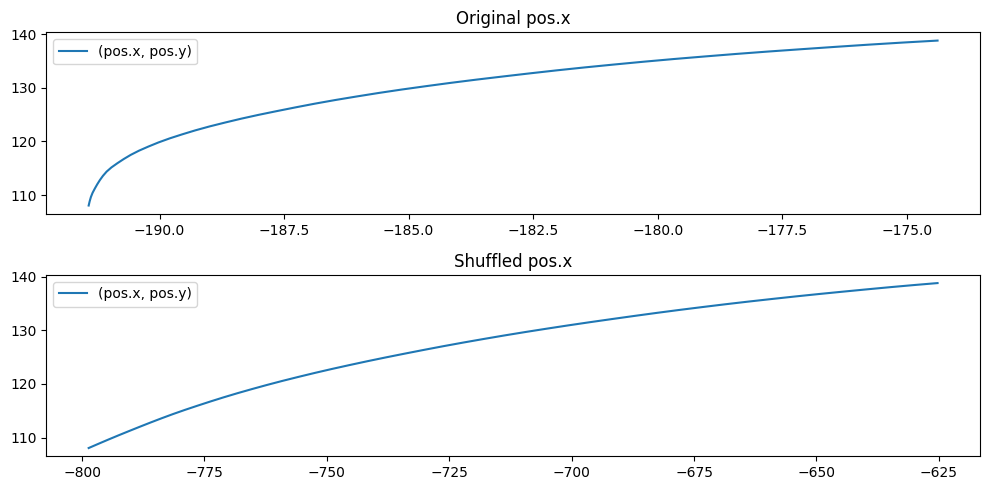

In [74]:
plot_pos(pos_x, pos_y, pos_x_shuffle)

In [75]:
import numpy as np

def perturb_time_series(matrix):
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(matrix, rowvar=False)
    
    # Initialize perturbation matrix
    perturbed_matrix = np.copy(matrix)
    
    # Iterate over each feature
    for i in range(matrix.shape[1]):
        # Find indices of features with high correlation with feature i
        correlated_features = np.where(np.abs(corr_matrix[i]) > 0.7)[0]
        
        # Compute perturbation values based on correlation grade
        for j in correlated_features:
            if i != j:
                perturbation_factor = corr_matrix[i, j]
                perturbed_matrix[:, j] += perturbation_factor * perturbed_matrix[:, i]
    
    # Add noise perturbation for features with low correlation
    for i in range(matrix.shape[1]):
        if np.abs(corr_matrix[i]).max() <= 0.7:
            perturbed_matrix[:, i] *= np.mean(perturbed_matrix[:, i])
    
    return perturbed_matrix


In [76]:
perturbed_matrix_2 = perturb_time_series(y)

/home/ab000840/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab000840/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [77]:
perturbed_matrix_2

array([[-625.27043231, -363.08746454,  -24.70158039,  532.57656257,
          28.44722427,    0.        , -173.18658249, -284.12026143],
       [-630.1216569 , -367.57861709,  -24.77631403,  537.22810388,
          28.53312815,    0.        , -175.28739624, -285.93455867],
       [-634.97572616, -372.09491078,  -24.70896879,  541.89516926,
          28.45574546,    0.        , -177.40116021, -287.75146758],
       [-639.81996143, -376.62354423,  -24.70892109,  546.56443532,
          28.45571324,    0.        , -179.52239724, -289.56619483],
       [-644.64830254, -381.14529356,  -24.7062897 ,  551.2193684 ,
          28.4526862 ,    0.        , -181.64254978, -291.37757433],
       [-649.46208156, -385.65780721,  -24.6935465 ,  555.86081187,
          28.43803248,    0.        , -183.76108052, -293.18700324],
       [-654.2585988 , -390.17759352,  -24.57246408,  560.50228311,
          28.29885464,    0.        , -185.88646912, -294.99194505],
       [-659.03258973, -394.70278085,  -2